In [1]:
import torch
import numpy as np
from path import Path
import sys
import scipy.spatial.distance
import math
import random
import utils
import random
from torch.utils.data import Dataset, DataLoader
from torchvision import models,transforms, utils
import os
import glob
import json
from collections import Counter, OrderedDict
from torchsummary import summary
import matplotlib.pyplot as plt
import cv2 
from PIL import Image
import time

In [2]:
import timm
import itertools
import pandas as pd
from pprint import pprint
import itertools
import pandas as pd

In [3]:
os.getcwd()

'/home/edshkim98/competition'

In [4]:
train_path = '/home/edshkim98/competition/train/'

In [5]:
os.listdir(train_path)

['370',
 '583',
 '110',
 '157',
 '315',
 '312',
 '408',
 '365',
 '904',
 '397',
 '293',
 '915',
 '693',
 '829',
 '169',
 '192',
 '506',
 '620',
 '817',
 '478',
 '566',
 '722',
 '796',
 '944',
 '442',
 '716',
 '396',
 '304',
 '949',
 '990',
 '911',
 '891',
 '286',
 '511',
 '73',
 '279',
 '372',
 '522',
 '856',
 '234',
 '329',
 '421',
 '229',
 '248',
 '318',
 '219',
 '571',
 '935',
 '811',
 '983',
 '917',
 '384',
 '514',
 '885',
 '201',
 '606',
 '357',
 '957',
 '34',
 '378',
 '653',
 '167',
 '76',
 '418',
 '243',
 '597',
 '231',
 '343',
 '444',
 '426',
 '227',
 '354',
 '501',
 '535',
 '913',
 '916',
 '532',
 '663',
 '843',
 '963',
 '810',
 '84',
 '334',
 '550',
 '616',
 '903',
 '621',
 '861',
 '50',
 '712',
 '381',
 '667',
 '486',
 '831',
 '955',
 '12',
 '235',
 '762',
 '886',
 '313',
 '193',
 '389',
 '682',
 '411',
 '609',
 '497',
 '55',
 '364',
 '143',
 '765',
 '2',
 '524',
 '391',
 '888',
 '763',
 '433',
 '258',
 '393',
 '799',
 '35',
 '927',
 '387',
 '851',
 '672',
 '146',
 '543',
 '

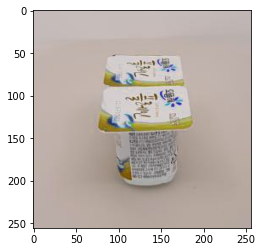

In [6]:
sample_image = train_path+'/370/33.jpg'
img = cv2.imread(sample_image)
plt.imshow(img)

In [7]:
train_transforms3 = transforms.Compose(
    [transforms.Resize(456,interpolation=Image.BICUBIC),
     transforms.RandomPerspective(),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms3 = transforms.Compose(
    [transforms.Resize(456,interpolation=Image.BICUBIC),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_transforms2 = transforms.Compose(
    [transforms.Resize(size=(384, 384),interpolation=Image.BICUBIC),
     transforms.RandomPerspective(),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms2 = transforms.Compose(
    [transforms.Resize(size=(384, 384),interpolation=Image.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

train_transforms = transforms.Compose(
    [transforms.Resize(224),
     transforms.RandomPerspective(),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose(
    [transforms.Resize(224),
     transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [8]:
class LotteDatasetB5(Dataset):
    def __init__(self, path, data, train=True, transform=None):
        self.path = path
        self.data = data
        self.files = []
        self.transform = transform
        self.train = train
        
        for i in self.data:
            sample = {}
            fname1 = i.split('/')[-2]
            fname = i
            label = fname1
            sample['path'] = fname
            sample['labels'] = int(label)
            self.files.append(sample)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name = self.files[idx]['path']
        label = self.files[idx]['labels']
        
        image = Image.open(img_name)
        if self.train == True:
            if random.uniform(0, 1):
                aug_f = transforms.RandomRotation((-30,30))
                image = aug_f(image)
        if self.transform is not None:
            image = self.transform(image)
        return {"image": np.array(image, dtype='float32'), "labels": label}
    

class LotteDataset_vit(Dataset):
    def __init__(self, path, data, train=True, transform=None):
        self.path = path
        self.data = data
        self.files = []
        self.transform = transform
        self.train = train
        
        for i in self.data:
            sample = {}
            fname1 = i.split('/')[-2]
            fname = i
            label = fname1
            sample['path'] = fname
            sample['labels'] = int(label)
            self.files.append(sample)
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_name = self.files[idx]['path']
        label = self.files[idx]['labels']
        
        image = Image.open(img_name)
        if self.train == True:
            if random.uniform(0, 1):
                aug_f = transforms.RandomRotation((-30,30))
                image = aug_f(image)
        if self.transform is not None:
            image = self.transform(image)
        return {"image": np.array(image, dtype='float32'), "labels": label}

In [9]:
def img_display(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [10]:
import torch.nn as nn
class SE(nn.Module):
    """
    Re-implementation of Squeeze-and-Excitation (SE) block described in:
        *Hu et al., Squeeze-and-Excitation Networks, arXiv:1709.01507*
    """

    def __init__(self, num_channels, reduction_ratio=2):
        """
        :param num_channels: No of input channels
        :param reduction_ratio: By how much should the num_channels should be reduced
        """
        super(SE, self).__init__()
        num_channels_reduced = num_channels // reduction_ratio
        self.reduction_ratio = reduction_ratio
        self.fc1 = nn.Linear(num_channels, num_channels_reduced, bias=True)
        self.fc2 = nn.Linear(num_channels_reduced, num_channels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, input_tensor):
        """
        :param input_tensor: X, shape = (batch_size, num_channels, H, W)
        :return: output tensor
        """
        batch_size, num_channels, H, W = input_tensor.size()
        # Average along each channel
        squeeze_tensor = input_tensor.view(batch_size, num_channels, -1).mean(dim=2)

        # channel excitation
        fc_out_1 = self.relu(self.fc1(squeeze_tensor))
        fc_out_2 = self.sigmoid(self.fc2(fc_out_1))

        a, b = squeeze_tensor.size()
        output_tensor = torch.mul(input_tensor, fc_out_2.view(a, b, 1, 1))
        return output_tensor

In [11]:
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, name, version,trained = True):#, args):
        super(Model2, self).__init__()
        self.name = name
        self.model = timm.create_model(self.name, pretrained=True)
        if version==1:
            for i in range(len(self.model.layer3)):
                self.model.layer3[i].se = SE(1024)

            for i in range(len(self.model.layer2)):
                self.model.layer2[i].se = SE(512)

            for i in range(len(self.model.layer1)):
                self.model.layer1[i].se = SE(256)
                
            for i in range(len(self.model.layer4)):
                self.model.layer4[i].se = SE(2048)
        if version==2:
            for i in range(len(self.model.layer4)):
                self.model.layer4[i].se = SE(2048)
        else:
            pass
                
        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.model.to(device)
        for param in self.model.parameters():
            param.requires_grad = trained        
    def forward(self,inputs):
        out = self.model(inputs)
        return out

In [12]:
from torch.optim import AdamW

In [13]:
def train_model(model,train_loader,val_loader,criterion, optimizer, scheduler, fname, epochs=25, save=True):
    best = 0
    best_loss = 100
    patience = 8
    cnt = 0
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    for epoch in range(epochs):
        e = epoch
        model.train()
        running_loss = 0
        print("Epoch: {}".format(e))
        for i, data in enumerate(train_loader):
            #scheduler.step()
            correct = 0
            inputs, labels = data['image'].to(device), data['labels'].to(device)
            optimizer.zero_grad()
            output = model(inputs)
            loss = criterion(output, labels)
            _,pred2 = torch.max(output.data,1)
            loss.backward()
            optimizer.step()
            scheduler.step()
            correct += (pred2 == labels).sum().item()
            acc = (correct/batch_size)*100
            if i%100 == 0:
                print("Epoch: {}, Loss:{:.6f}, ACC:{:.6f}".format(epoch,loss.item(),acc))
            
        model.eval()
        total = 0
        correct =0
        loss =[]
        with torch.no_grad():  
            for i, data in enumerate(val_loader):
                inputs, labels = data['image'].to(device), data['labels'].to(device)
                output = model(inputs)
                ls = criterion(output, labels)
                _,pred2 = torch.max(output.data,1)
                
                loss.append(ls.item())
                total += batch_size_test
                correct += (pred2 == labels).sum().item()
                
            acc = 100. * correct / total
                #100. * correct/total
            loss_final = np.mean(loss)
            print("The validation accuracy: {:.6f} and the validation loss: {:.6f}".format(acc,loss_final))
            if acc > best:
                best = acc
            if loss_final < best_loss:
                cnt = 0
                best_loss = loss_final
                #if str(fname)+'pth' in os.listdir('/home/edshkim98/competition/'):
                #    if save:
                #        torch.save(model.state_dict(), '/home/edshkim98/competition/'+str(fname)+"__2.pth")
                #else:
                if save:
                    torch.save(model.state_dict(), '/home/edshkim98/competition/'+str(fname)+".pth")
            else:
                cnt +=1
                print("Patience: ",cnt)
                if cnt == patience:
                    return 0
    return 0


Mode, Model: ig_resnext101_32x32d
Else
torch.Size([12, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Train size:  36000
Test size:  12000
Version0
Epoch: 0
Epoch: 0, Loss:7.956710, ACC:0.000000
Epoch: 0, Loss:6.938400, ACC:0.000000
Epoch: 0, Loss:7.019053, ACC:0.000000
Epoch: 0, Loss:6.827894, ACC:0.000000
Epoch: 0, Loss:6.841166, ACC:0.000000
Epoch: 0, Loss:6.789816, ACC:0.000000
Epoch: 0, Loss:6.581535, ACC:0.000000
Epoch: 0, Loss:6.714808, ACC:16.666667
Epoch: 0, Loss:5.834920, ACC:8.333333
Epoch: 0, Loss:5.376402, ACC:8.333333
Epoch: 0, Loss:3.640547, ACC:33.333333
Epoch: 0, Loss:2.866122, ACC:50.000000
Epoch: 0, Loss:1.970464, ACC:66.666667
Epoch: 0, Loss:1.486997, ACC:91.666667
Epoch: 0, Loss:1.759696, ACC:66.666667
Epoch: 0, Loss:1.089222, ACC:75.000000
Epoch: 0, Loss:0.194464, ACC:100.000000
Epoch: 0, Loss:0.461861, ACC:91.666667
Epoch: 0, Loss:0.615959, ACC:91.666667
Epoch: 0, Loss:0.466127, ACC:91.666667
Epoch: 0, Loss:0.097414, ACC:100.000000
Epoch: 0, Loss:0.674229, ACC:66.666667
Epoch: 0, Loss:0.162055, ACC:100.000000
Epoch: 0, Loss:0.303866, ACC:91.666667
Epoch: 0, Loss:

Epoch: 6, Loss:0.034202, ACC:100.000000
Epoch: 6, Loss:0.016457, ACC:100.000000
Epoch: 6, Loss:0.007548, ACC:100.000000
Epoch: 6, Loss:0.008437, ACC:100.000000
Epoch: 6, Loss:0.003184, ACC:100.000000
Epoch: 6, Loss:0.011865, ACC:100.000000
Epoch: 6, Loss:0.000743, ACC:100.000000
Epoch: 6, Loss:0.001972, ACC:100.000000
Epoch: 6, Loss:0.011969, ACC:100.000000
Epoch: 6, Loss:0.016141, ACC:100.000000
Epoch: 6, Loss:0.005859, ACC:100.000000
Epoch: 6, Loss:0.003427, ACC:100.000000
Epoch: 6, Loss:0.003146, ACC:100.000000
Epoch: 6, Loss:0.025370, ACC:100.000000
Epoch: 6, Loss:0.004215, ACC:100.000000
Epoch: 6, Loss:0.002644, ACC:100.000000
Epoch: 6, Loss:0.012478, ACC:100.000000
The validation accuracy: 99.825000 and the validation loss: 0.006270
Epoch: 7
Epoch: 7, Loss:0.001184, ACC:100.000000
Epoch: 7, Loss:0.001401, ACC:100.000000
Epoch: 7, Loss:0.004798, ACC:100.000000
Epoch: 7, Loss:0.006241, ACC:100.000000
Epoch: 7, Loss:0.033123, ACC:100.000000
Epoch: 7, Loss:0.001044, ACC:100.000000
Ep

KeyboardInterrupt: 

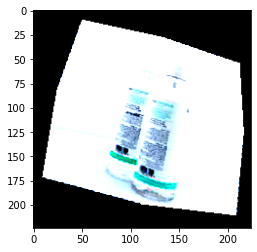

In [14]:
nets = ['tf_efficientnet_b5_ns','swsl_resnext101_32x16d','vit_deit_base_distilled_patch16_384','tf_efficientnet_b5_ns']
#Too bad: rexnet_200 ig_resnext101_32x8d  swsl_resnet50 wide_resnet50_2 se_resnetx tf_efficientnet_b4_ns
#V good: ig_resnext101_32x16d##
torch.cuda.set_device(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
versions = ['SGD','Adam']#[0,2]
for ver in versions:
    for net in nets:
        num=0
        print("Mode, Model: {}".format(net))
        categories = glob.glob(train_path+'*')
        categories = [i.split('/')[-1] for i in categories]
        train_files = []
        test_files = []
        idx = np.random.choice(48,12,replace=False)
        for category in categories:
            files = glob.glob(train_path+category+'/*')
            files_test = np.array(files)[idx]
            files_train = []
            for i in files:
                if i not in files_test:
                    files_train.append(i)
            train_files.append(files_train)
            test_files.append(files_test)

        test_files = list(itertools.chain.from_iterable(test_files))
        train_files = list(itertools.chain.from_iterable(train_files))

        if 'vit' in net:
            print("VIT")
            train_dataset = LotteDataset_vit(train_path,train_files, train=True,transform =train_transforms2)
            test_dataset = LotteDataset_vit(train_path,test_files, train=False,transform =valid_transforms2)
        elif 'efficient' in net:
            print('efficient')
            train_dataset = LotteDatasetB5(train_path,train_files, train=True,transform =train_transforms3)
            test_dataset = LotteDatasetB5(train_path,test_files, train=False,transform =valid_transforms3)
        else:
            print('Else')
            train_dataset = LotteDatasetB5(train_path,train_files, train=True,transform =train_transforms)
            test_dataset = LotteDatasetB5(train_path,test_files, train=False,transform =valid_transforms)        
        
        batch_size = 12
        batch_size_test = 1
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last = True, num_workers=2)
        val_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=False, drop_last = True, num_workers=2)
        print(next(iter(train_loader))['image'].shape)
        pix = next(iter(train_loader))['image'][0]
        plt.imshow(img_display(pix))
        print("Train size: ",len(train_loader)*batch_size)
        print("Test size: ",len(val_loader)*batch_size_test)
        if 'se_resnetx' not in net:
            print("Version0")
            custom_model = Model(name=net, version=0)
        else:
            print("Version0")
            custom_model = Model(name=net, version=ver)

        criterion = nn.CrossEntropyLoss()
        #custom_model.to(device)
        # Observe that all parameters are being optimized
        if ver == 'SGD':
            optimizer = torch.optim.SGD(custom_model.parameters(), lr=0.001, momentum=0.9)
        if ver == 'Adam':
            optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.001)

        step = 1
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, step*len(train_loader), eta_min=1e-4)
        if net == 'ig_resnext101_32x16d':
            fname = 'ig_resnext101_32x16d_se2'
        else:
            fname = net
        train_model(custom_model, train_loader, val_loader, criterion, optimizer, scheduler, fname)

In [ ]:
#Best performance model: SE custom ResNext -> ResNext -> EfficientNet -> ResNet